# MP4 Weed Detection

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import os
from datetime import datetime
from google.colab import files
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
    print(f"Using GPU: {physical_devices}")
else:
    print("No GPU found, using CPU")

def preprocess_frame(frame, target_size):
    """Optimized preprocessing for frames"""
    resized = cv2.resize(frame, (target_size[1], target_size[0]))
    rgb_frame = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    normalized = rgb_frame / 255.0

    batched = np.expand_dims(normalized, axis=0)

    return batched

In [ ]:
def batch_preprocess_frames(frames, target_size):
    """Process multiple frames as a batch"""
    batch = np.zeros((len(frames), target_size[0], target_size[1], 3), dtype=np.float32)

    for i, frame in enumerate(frames):
        resized = cv2.resize(frame, (target_size[1], target_size[0]))
        rgb_frame = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)

        batch[i] = rgb_frame / 255.0

    return batch

In [ ]:
def check_top_activity_position(frame, threshold=0.1):

    height, width = frame.shape[:2]
    top_half_height = height // 2
    section_width = width // 3

    top_left = frame[:top_half_height, :section_width]
    top_center = frame[:top_half_height, section_width:2*section_width]
    top_right = frame[:top_half_height, 2*section_width:]

    def get_activity_level(section):
        gray = cv2.cvtColor(section, cv2.COLOR_BGR2GRAY)
        std_dev = np.std(gray)
        return std_dev

    activity_left = get_activity_level(top_left)
    activity_center = get_activity_level(top_center)
    activity_right = get_activity_level(top_right)

    has_left_activity = activity_left > threshold
    has_center_activity = activity_center > threshold
    has_right_activity = activity_right > threshold

    any_activity = has_left_activity or has_center_activity or has_right_activity

    position_info = {
        'left': activity_left,
        'center': activity_center,
        'right': activity_right,
        'has_left': has_left_activity,
        'has_center': has_center_activity,
        'has_right': has_right_activity
    }

    return any_activity, position_info

In [ ]:
def calculate_position_penalty(position_info, center_penalty=0.25, side_penalty=0.1):

    penalty = 0.0

    if position_info['has_center']:
        center_weight = min(1.0, position_info['center'] / 30)
        penalty = max(penalty, center_penalty * center_weight)

    if position_info['has_left']:
        left_weight = min(1.0, position_info['left'] / 30)
        penalty = max(penalty, side_penalty * left_weight)

    if position_info['has_right']:
        right_weight = min(1.0, position_info['right'] / 30)
        penalty = max(penalty, side_penalty * right_weight)

    return penalty

In [ ]:
def draw_confidence_bar(frame, confidence_score, position_info=None, has_top_activity=False,
                       center_penalty_factor=0.25, side_penalty_factor=0.1, bonus_factor=0.1, threshold=0.8):
    height, width = frame.shape[:2]


    original_confidence = confidence_score

    if has_top_activity and position_info:

        position_based_penalty = calculate_position_penalty(
            position_info, center_penalty_factor, side_penalty_factor)


        confidence_score = max(0, confidence_score - (confidence_score * position_based_penalty))
    elif not has_top_activity:

        bonus = confidence_score * bonus_factor
        confidence_score = min(1.0, confidence_score + bonus)

    overlay = frame.copy()
    overlay_height = int(height * 0.12)
    overlay_y = height - overlay_height
    cv2.rectangle(overlay,
                 (0, overlay_y),
                 (width, height),
                 (20, 20, 20),
                 -1)

    alpha = 0.85
    cv2.addWeighted(overlay[overlay_y:height, 0:width], alpha,
                   frame[overlay_y:height, 0:width], 1-alpha,
                   0, frame[overlay_y:height, 0:width])

    bar_height = int(height * 0.025)
    max_bar_width = int(width * 0.6)
    bar_width = int(max_bar_width * confidence_score)
    bar_start_x = int(width * 0.25)
    bar_start_y = height - int(height * 0.06)

    bg_color = (60, 60, 60)
    cv2.rectangle(frame,
                 (bar_start_x, bar_start_y),
                 (bar_start_x + max_bar_width, bar_start_y + bar_height),
                 bg_color,
                 -1)

    if confidence_score >= threshold:

        r = int(255 * (1 - (confidence_score - threshold) / (1 - threshold)))
        g = 255
        b = 0
        color = (b, g, r)
    else:
        r = 255
        g = int(255 * (confidence_score / threshold))
        b = 0
        color = (b, g, r)

    if bar_width > 0:
        cv2.rectangle(frame,
                     (bar_start_x, bar_start_y),
                     (bar_start_x + bar_width, bar_start_y + bar_height),
                     color,
                     -1)

    highlight_thickness = max(1, int(bar_height * 0.2))
    cv2.line(frame,
            (bar_start_x, bar_start_y),
            (bar_start_x + max_bar_width, bar_start_y),
            (120, 120, 120), highlight_thickness)

    percentage = f"{int(confidence_score * 100)}%"
    label = "Confidence"

    font = cv2.FONT_HERSHEY_DUPLEX
    font_scale_label = 0.65
    font_scale_percentage = 0.85
    font_color = (240, 240, 240)
    font_thickness = 1

    text_percentage = percentage
    text_size = cv2.getTextSize(text_percentage, font, font_scale_percentage, font_thickness)[0]
    text_x = bar_start_x + max_bar_width + 15
    text_y = bar_start_y + bar_height // 2 + text_size[1] // 2

    text_label = label
    label_size = cv2.getTextSize(text_label, font, font_scale_label, font_thickness)[0]
    label_x = bar_start_x - label_size[0] - 15
    label_y = bar_start_y + bar_height // 2 + label_size[1] // 2

    if label_x < 10:
        shift_amount = 10 - label_x
        bar_start_x += shift_amount
        label_x = 10
        text_x += shift_amount

    cv2.putText(frame, text_percentage, (text_x+1, text_y+1), font,
                font_scale_percentage, (0, 0, 0), font_thickness + 1)
    cv2.putText(frame, text_percentage, (text_x, text_y), font,
                font_scale_percentage, font_color, font_thickness)

    cv2.putText(frame, text_label, (label_x+1, label_y+1), font,
                font_scale_label, (0, 0, 0), font_thickness + 1)
    cv2.putText(frame, text_label, (label_x, label_y), font,
                font_scale_label, font_color, font_thickness)

    for i in range(1, 10):
        tick_x = bar_start_x + (max_bar_width * i) // 10
        tick_height = bar_height // 3
        tick_color = (80, 80, 80)
        cv2.line(frame,
                (tick_x, bar_start_y + bar_height - tick_height),
                (tick_x, bar_start_y + bar_height),
                tick_color, 1)

    return frame


In [ ]:
def process_video(video_path, model_path, output_path=None, confidence_threshold=0.8,
                 batch_size=8, frame_skip=2,
                 center_penalty_factor=0.25, side_penalty_factor=0.1,
                 bonus_factor=0.1, activity_threshold=0.1):

    start_time = time.time()


    print(f"Loading model from {model_path}...")
    model = load_model(model_path)

    if len(model.input_shape) == 4:
        input_shape = model.input_shape[1:3]
    else:
        input_shape = (224, 224)

    print(f"Model input shape: {input_shape}")

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open video file: {video_path}")

    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Video properties: {width}x{height}, {fps} FPS, {total_frames} frames")
    print(f"Processing with batch size {batch_size}, processing 1 frame every {frame_skip} frames")
    print(f"Center penalty: {center_penalty_factor}, side penalty: {side_penalty_factor}, " +
         f"bonus: {bonus_factor}, activity threshold: {activity_threshold}")

    if output_path is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        output_path = f"processed_video_{timestamp}.mp4"

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps/frame_skip, (width, height))

    frame_count = 0
    high_confidence_frames = 0
    penalized_frames = 0
    rewarded_frames = 0

    center_penalty_count = 0
    left_penalty_count = 0
    right_penalty_count = 0


    pbar = tqdm(total=total_frames)


    batch_frames = []
    original_frames = []
    top_activity_flags = []
    position_info_list = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        pbar.update(1)


        if frame_count % frame_skip != 0:
            continue

        original_frames.append(frame.copy())

        has_top_activity, position_info = check_top_activity_position(frame, activity_threshold)
        top_activity_flags.append(has_top_activity)
        position_info_list.append(position_info)

        batch_frames.append(frame)

        if len(batch_frames) == batch_size or not ret:
            if batch_frames:
                batch_input = batch_preprocess_frames(batch_frames, input_shape)

                batch_predictions = model.predict(batch_input, verbose=0)

                for i, (orig_frame, prediction, has_top_activity, position_info) in enumerate(
                        zip(original_frames, batch_predictions, top_activity_flags, position_info_list)):
                    if isinstance(prediction, list):
                        prediction = prediction[0]

                    if prediction.size > 1:
                        confidence_score = np.max(prediction)
                    else:
                        confidence_score = float(prediction[0])

                    processed_frame = orig_frame.copy()
                    processed_frame = draw_confidence_bar(
                        processed_frame,
                        confidence_score,
                        position_info=position_info,
                        has_top_activity=has_top_activity,
                        center_penalty_factor=center_penalty_factor,
                        side_penalty_factor=side_penalty_factor,
                        bonus_factor=bonus_factor,
                        threshold=confidence_threshold
                    )

                    if has_top_activity:
                        penalty = calculate_position_penalty(
                            position_info, center_penalty_factor, side_penalty_factor)

                        confidence_score = max(0, confidence_score - (confidence_score * penalty))
                        penalized_frames += 1


                        if position_info['has_center']:
                            center_penalty_count += 1
                        if position_info['has_left']:
                            left_penalty_count += 1
                        if position_info['has_right']:
                            right_penalty_count += 1
                    else:
                        confidence_score = min(1.0, confidence_score + (confidence_score * bonus_factor))
                        rewarded_frames += 1


                    if confidence_score >= confidence_threshold:
                        high_confidence_frames += 1

                    out.write(processed_frame)

                batch_frames = []
                original_frames = []
                top_activity_flags = []
                position_info_list = []


    cap.release()
    out.release()
    pbar.close()

    end_time = time.time()
    processing_time = end_time - start_time
    frames_per_second = total_frames / processing_time

    print(f"Processing complete in {processing_time:.2f} seconds!")
    print(f"Processed at {frames_per_second:.2f} frames per second")
    print(f"{high_confidence_frames} frames had confidence scores above {confidence_threshold} after adjustments")
    print(f"{penalized_frames} frames were penalized for activity in the top half:")
    print(f"  - {center_penalty_count} frames had activity in the CENTER (higher penalty)")
    print(f"  - {left_penalty_count} frames had activity in the LEFT")
    print(f"  - {right_penalty_count} frames had activity in the RIGHT")
    print(f"{rewarded_frames} frames were rewarded for having a clear top half")
    print(f"Output saved to: {output_path}")

    return output_path

In [ ]:
def display_sample_frames(video_path, num_frames=5):
    """Display sample frames from the processed video"""
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    indices = np.linspace(0, total_frames-1, num_frames, dtype=int)

    plt.figure(figsize=(15, 10))
    for i, frame_idx in enumerate(indices):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if ret:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            plt.subplot(1, num_frames, i+1)
            plt.imshow(frame_rgb)
            plt.title(f"Frame {frame_idx}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    cap.release()

No GPU found, using CPU
Please upload your MP4 video file:


Saving input_slow.mp4 to input_slow (24).mp4
Video file uploaded: input_slow (24).mp4

Please upload your model file (deepweeds_binary_final.h5):


Saving deepweeds_binary_final.h5 to deepweeds_binary_final (25).h5
Model file uploaded: deepweeds_binary_final (25).h5
Loading model from deepweeds_binary_final (25).h5...


Model input shape: (224, 224)
Video properties: 640x480, 30.0 FPS, 2415 frames
Processing with batch size 8, processing 1 frame every 1 frames
Center penalty: 0.25, side penalty: 0.05, bonus: 0.4, activity threshold: 0.1


  0%|          | 0/2415 [00:00<?, ?it/s]

Processing complete in 161.92 seconds!
Processed at 14.92 frames per second
48 frames had confidence scores above 0.7 after adjustments
2376 frames were penalized for activity in the top half:
  - 2212 frames had activity in the CENTER (higher penalty)
  - 2268 frames had activity in the LEFT
  - 2185 frames had activity in the RIGHT
32 frames were rewarded for having a clear top half
Output saved to: processed_video_20250330_125428.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

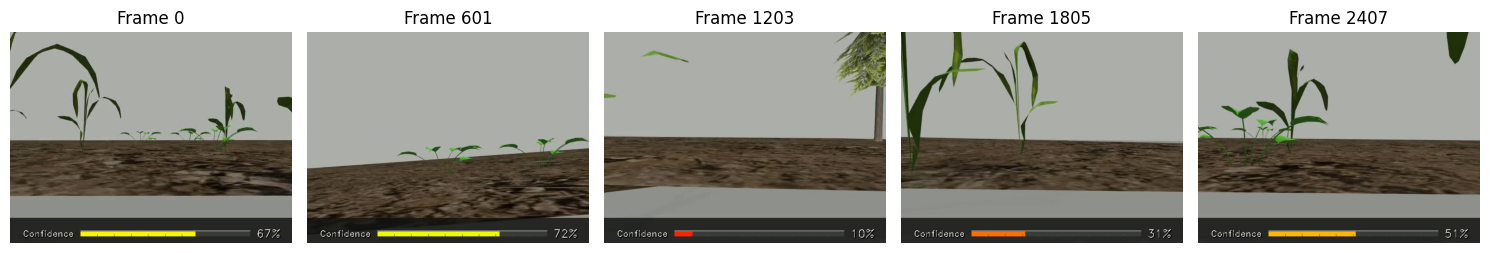

In [30]:
print("Please upload your MP4 video file:")
uploaded_video = files.upload()
video_path = list(uploaded_video.keys())[0]
print(f"Video file uploaded: {video_path}")

print("\nPlease upload your model file (deepweeds_binary_final.h5):")
uploaded_model = files.upload()
model_path = list(uploaded_model.keys())[0]
print(f"Model file uploaded: {model_path}")

output_video_path = process_video(
    video_path=video_path,
    model_path=model_path,
    confidence_threshold=0.7,
    batch_size=8,
    frame_skip=1,
    center_penalty_factor=0.25,
    side_penalty_factor=0.05,
    bonus_factor=0.4,
    activity_threshold=0.1
)


files.download(output_video_path)

display_sample_frames(output_video_path)